# Make signature network using the `CD_center_LM` signatures 

In [1]:
import os, sys, json
from collections import Counter
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial import distance as dist
from sklearn import neighbors
from pymongo import MongoClient

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# Plot degree distribution
def plot_degree_distribution(G):
    fig, ax = plt.subplots()
    
    degrees = G.degree().values()
    degrees = dict(Counter(degrees))
    x = degrees.keys()
    y = degrees.values()

    ax.scatter(x, y, s=10, alpha=.6)
    ax.set_xlabel('Degree', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)    
    ax.set_xscale('log')
    ax.set_yscale('log')
    return ax


In [3]:
## Load signature metadata mongodb
client = MongoClient('mongodb://146.203.54.131:27017/')
coll = client['L1000FWD']['sigs']
cur = coll.find({'SCS_centered_by_batch': {'$lt': 0.05}},  
                {'_id':False, 
                 'sig_id':True, 
                 'SCS_centered_by_batch':True,
                 'pert_id':True,
                 'cell_id':True,
                 'pert_dose':True,
                })

sig_meta_df = pd.DataFrame([doc for doc in cur]).set_index('sig_id')
sig_meta_df.rename(index=str,columns={'SCS_centered_by_batch':'pvalue'}, inplace=True)
print sig_meta_df.shape
sig_meta_df.head()

(48098, 4)


,pvalue,cell_id,pert_dose,pert_id
sig_id,,,,
LJP001_HS578T_24H:BRD-K52911425-001-04-9:2,0.0028,HS578T,2.0,BRD-K52911425
LJP001_HS578T_24H:BRD-K69932463-001-05-6:10,0.0483,HS578T,10.0,BRD-K69932463
LJP001_HS578T_24H:BRD-K85606544-001-04-2:10,0.0007,HS578T,10.0,BRD-K85606544
LJP001_HS578T_24H:BRD-K72636697-001-01-5:10,0.0000,HS578T,10.0,BRD-K72636697
LJP001_HS578T_24H:BRD-K13390322-001-02-2:0.4,0.0000,HS578T,0.4,BRD-K13390322


In [4]:
# sig_meta_df['batch'] = sig_meta_df.index.map(lambda x:x.split(':')[0])
# sig_meta_df['time'] = sig_meta_df['batch'].map(lambda x:x.split('_')[2].strip('H'))
# sig_meta_df.to_csv('../data/metadata-L1000FWD.tsv', sep='\t')

In [4]:
# Get the top 50 significant signatures for each pert_id
def pick_top_sigs(x):
    x = x.sort_values(ascending=True)
    n_significants = (x < 0.05).sum()
    if n_significants == 0:
        return x.head(2)
    else:
        return x.head(n_significants)

# grouped_sorted = sig_meta_df.groupby('pert_id')['pvalue'].apply(pick_top_sigs)

grouped_sorted = sig_meta_df.groupby('pert_id')['pvalue'].apply(lambda x: x.sort_values(ascending=True).head(20))

print grouped_sorted.shape
grouped_sorted.head()

(34502,)


pert_id        sig_id                                   
BRD-A00100033  CPC015_PHH_24H:BRD-A00100033-001-04-8:10     0.0203
BRD-A00267231  CPC001_PC3_6H:BRD-A00267231-001-01-1:10      0.0007
               CPC001_HA1E_24H:BRD-A00267231-001-01-1:10    0.0022
               CPC017_ASC_24H:BRD-A00267231-001-01-1:10     0.0126
               CPC017_A549_6H:BRD-A00267231-001-01-1:10     0.0228
Name: pvalue, dtype: float64

pert_id
BRD-K03109492    20
BRD-K64890080    20
BRD-K59962020    20
BRD-K59469039    20
BRD-A48237631    20
BRD-K59369769    20
BRD-K59184148    20
BRD-K58772419    20
BRD-A11678676    20
BRD-A49680073    20
BRD-K57080016    20
BRD-K57011718    20
BRD-K56957086    20
BRD-K56700933    20
BRD-K56477805    20
BRD-K56411643    20
BRD-K56343971    20
BRD-A50737080    20
BRD-K92093830    20
BRD-K56301217    20
BRD-K55468218    20
BRD-K55127134    20
BRD-K92241597    20
BRD-K92301463    20
BRD-K92317137    20
BRD-A52530684    20
BRD-A52650764    20
BRD-K92428232    20
BRD-K54256913    20
BRD-K54233340    20
BRD-K53972329    20
BRD-K91623615    20
BRD-K60219430    20
BRD-K60230970    20
BRD-A43331270    20
BRD-K64800655    20
BRD-K64642496    20
BRD-K64634304    20
BRD-K64606589    20
BRD-K64052750    20
BRD-K64024097    20
BRD-K90826279    20
BRD-K63923597    20
BRD-K63828191    20
BRD-K63675182    20
BRD-A13122391    20
BRD-K90999434    20
BRD-A13084692    20
BRD-K63195589    20
BRD-K9150912

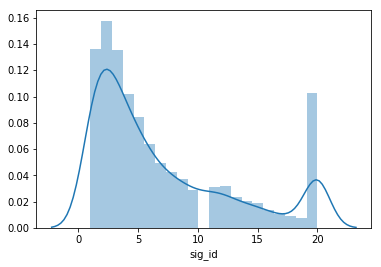

In [5]:
# filter out pert_id with less than 5 signatures
pert_id_counts = grouped_sorted.reset_index().groupby('pert_id')['sig_id'].count()
print pert_id_counts.sort_values(ascending=False)[:50]
sns.distplot(pert_id_counts)

In [7]:
pert_ids_kept = pert_id_counts[pert_id_counts > 0].index.tolist()
# pert_ids_kept = pert_id_counts[pert_id_counts > 10].index.tolist()
print 'Number of pert_id to keep: %d' % len(pert_ids_kept)

Number of pert_id to keep: 4944


In [8]:
grouped_sorted = grouped_sorted[pert_ids_kept].reset_index()
print grouped_sorted.shape
n_sigs = grouped_sorted.shape[0]
print 'Number of sig_id to keep: %d' % n_sigs


(34502, 3)
Number of sig_id to keep: 34502


In [9]:
grouped_sorted.head()

,pert_id,sig_id,pvalue
0,BRD-A00100033,CPC015_PHH_24H:BRD-A00100033-001-04-8:10,0.0203
1,BRD-A00267231,CPC001_PC3_6H:BRD-A00267231-001-01-1:10,0.0007
2,BRD-A00267231,CPC001_HA1E_24H:BRD-A00267231-001-01-1:10,0.0022
3,BRD-A00267231,CPC017_ASC_24H:BRD-A00267231-001-01-1:10,0.0126
4,BRD-A00267231,CPC017_A549_6H:BRD-A00267231-001-01-1:10,0.0228


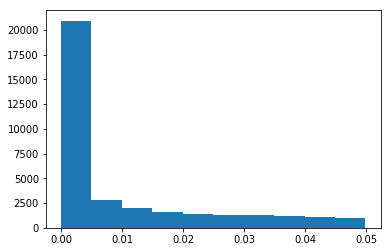

In [10]:
plt.hist(grouped_sorted['pvalue']);

In [11]:
def retrieve_sig_mat(sig_ids, coll, key):
    '''Retrieve signatures matrix from MongoDB'''
    # Retrieve signature matrix
    sig_mat = np.zeros((len(sig_ids), 978))
    for i, sig_id in enumerate(sig_ids): 
        doc = coll.find_one({'sig_id': sig_id}, {'_id':False, key:True})
        sig_mat[i] = doc[key]
        if i % 5000 == 0:
            print i, len(sig_ids)
    return sig_mat

In [12]:
## Extract signature matrix
mat = retrieve_sig_mat(grouped_sorted['sig_id'], coll, 'CD_center_LM')
print mat.shape

0 34502
5000 34502
10000 34502
15000 34502
20000 34502
25000 34502
30000 34502
(34502, 978)


In [18]:
from scipy.spatial import distance as dist

def compute_adjcency_mat(X, metric='cosine'):
    adj_mat = dist.squareform(pairwise_distances(X, metric=metric))
    adj_mat = 1 - adj_mat
    
    
    # remove 1's on the diagnal
#     adj_mat -= np.eye(X.shape[0])
    ## convert negative values in adj_mat to 0's
    adj_mat[adj_mat<0] = 0
    return adj_mat

def create_graph_by_threshold(adj_mat, percentile):
    thresold = np.percentile(adj_mat, percentile)
    adj_mat_ = adj_mat.copy()
    adj_mat_[adj_mat<thresold] = 0
    G = nx.from_numpy_matrix(dist.squareform(adj_mat_))
    return G

def create_graph_by_threshold2(adj_mat, cosine_cutoff):
    adj_mat_ = adj_mat.copy()
    adj_mat_[adj_mat<cosine_cutoff] = 0
    G = nx.from_numpy_matrix(dist.squareform(adj_mat))
    return G
    

def create_knn_graph(X, k=30, metric='euclidean', n_jobs=1):
    '''Create a graph from a data matrix (sample x features).
    '''
    adj_mat = neighbors.kneighbors_graph(X, k, mode='connectivity', 
                                         metric=metric,
                                         n_jobs=n_jobs
                                        )
    G = nx.from_scipy_sparse_matrix(adj_mat)
    return G


In [16]:
def filter_out_small_ccs(G, cutoff=10):
    ## Create a new graph only keeping the large connected components
    G_new = nx.Graph()
    for cc in nx.connected_component_subgraphs(G):
        if cc.number_of_nodes() > cutoff:
            G_new = nx.compose(G_new, cc)
    return G_new

In [14]:
# Compute the pairwise cosine distance and convert to adjacency matrix
adj_mat = compute_adjcency_mat(mat)
print adj_mat.shape

(595176751,)


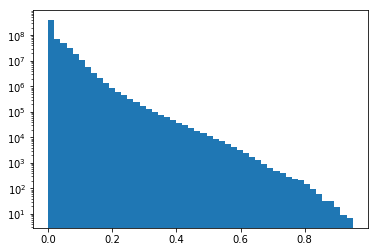

In [15]:
plt.hist(adj_mat, bins=50, log=True);

In [20]:
# Create network by applying threshold 
G = create_graph_by_threshold(adj_mat, 99.9)
# G = create_graph_by_threshold2(adj_mat, 0.4)
# G = create_graph_by_threshold2(adj_mat, 0.3)
# G = create_graph_by_threshold2(adj_mat, 0.35)
print G.number_of_nodes(), G.number_of_edges()
G_new = filter_out_small_ccs(G)
print G_new.number_of_nodes(), G_new.number_of_edges()

34502 595177
16848 594372


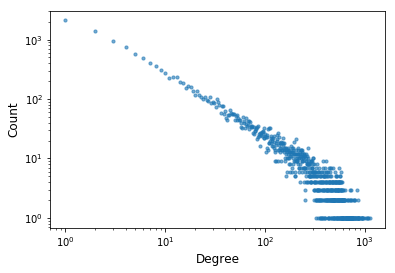

In [21]:
plot_degree_distribution(G_new)

In [22]:
# Relabel nodes with sig_ids
sig_ids_shared = grouped_sorted['sig_id'].tolist()
d_id_sig_id = dict(zip(range(len(sig_ids_shared)), sig_ids_shared))
d_id_sig_id = {nid: sig_id for nid, sig_id in d_id_sig_id.items() if G_new.has_node(nid)}
nx.relabel_nodes(G_new, d_id_sig_id, copy=False)
# print G_new.nodes()[:5]

In [23]:
# Report G_new stats
sig_meta_df_sub = sig_meta_df.loc[list(G_new.nodes())]
print sig_meta_df_sub.shape
print 'Unique pert_ids:', sig_meta_df_sub['pert_id'].nunique()
print 'Unique cell lines:', sig_meta_df_sub['cell_id'].nunique()

(16848, 4)
Unique pert_ids: 3237
Unique cell lines: 68


In [24]:
nx.write_gml(G_new, 'Signature_Graph_CD_center_LM_sig-only_%dnodes.gml' % G_new.number_of_nodes())

In [27]:
k = 3

In [28]:
# Create a graph by kNN
G = create_knn_graph(mat, k=k, n_jobs=6)
print G.number_of_nodes(), G.number_of_edges()

34434 88913


In [31]:
# nx.write_gml(G_new, 'Signature_Graph_CD_center_LM_%dnodes_%s.gml' % (G_new.number_of_nodes(), percentile_cutoff))
nx.write_gml(G_new, 'Signature_Graph_CD_center_LM_%dnodes_kNN%d.gml' % (G_new.number_of_nodes(), k))